# Project 3: Identifying Wilderness vs Zombie Survival Subreddits using API & NLP
#### By: _Leticia G._

# Problem Statement
A popular forum social media, Reddit is a site where people can share posts, creates polls, and vote on good or bad posts by up and down voting them. Centered around sharing opinions, seeking advice, and engaging in discourse in specified subreddits on topics Reddit is a useful site to learn about people's thoughts regarding a news, products, shows, and other topics. This project aims to develop classification models that can correctly specify which of two subreddits a post originated from based on the title and description of the post. The subreddit of choice are "Survival" which provides wilderness survival tips, and "Zombie Survival Tactics" which provide advice if there were ever a zombie apocalypse. This project aims to discover useful insights for the movie and television production market to see what survivalists and preppers discuss or desire.


# Background Info/Outside Research:
3.7 million Americans classify themselves as survivalists and list some of their biggest concerns as economic collapse, grid failure, natural disasters, and terrorist attack. This community prepares for the worst with reddit as place they turn to for advice and podcasts like "The Survival Podcast", "The Survival Show", "The Survivalist Prepper Podcast" and shows like DoomsDay Preppers. A portion of these survivalists, approximately 14% according to a poll ran by You Gov, have a zombie survival plan prepared. 24% of these survivalists are Millennials, 15% being Generation X, and 6% being Boomers.

According to Allied Market Research the "emergency management" industry, which the survivalist market falls under, is valued at $107 billion dollars. Needless to say, there is a huge opportunity to appeal to and cash in on.

## Imports

In [2]:
import re
import requests
import time
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# NLP lesson
from nltk.corpus import stopwords
import nltk
# nltk.download('punkt')

# NLP II lesson
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

## Check the data, clean, drop unnecessary columns, nulls, and concat reddits into one database

In [3]:
# Code noted from Noah Christiansen's GA Instructor's Review

def query_pushshift(subreddit, kind = 'submission', day_window = 10, n = 80):
    SUBFIELDS = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self']
    
    # Establish base url and stem for iteration of multiple subreddits
    BASE_URL = f"https://api.pushshift.io/reddit/search/{kind}" # aka "API endpoint"
    stem = f"{BASE_URL}?subreddit={subreddit}&size=100" # we are pulling the max number of posts, size 100.

    # Instantiate empty list for temp storage of posts
    posts = []
    
    # Implement for loop with `time.sleep(2)` 
    # Pull posts from json after requesting URL, ensure no errors,and append to df, repeat.
    for i in range(1, n + 1):
        # create custom URL using `after`
        URL = f"{stem}&after={day_window*i}d"
        print("Querying from: " + URL)
        res = requests.get(URL)
        assert res.status_code == 200
        json = res.json()['data']
        df = pd.DataFrame(json)
        posts.append(df)
        time.sleep(2)
    
    # pd.concat storage list to build full dataframe
    full = pd.concat(posts)
    
    # If submission posts then select columns, drop duplicates, is_self=True, and create the full dataframe
    if kind == "submission":
        # Select only the desired columns from the information
        full = full[SUBFIELDS].copy()
        
        # Drop any duplicate posts
        full.drop_duplicates(inplace = True)
        
        # select `is_self` == True
        full = full.loc[full["is_self"] == True]

    # Create `timestamp` column converted from UTC
    full["timestamp"] = full["created_utc"].map(dt.date.fromtimestamp)
    
    print("Query complete!")
    return full

In [4]:
reddit_1 = query_pushshift("Survival")
#gathering posts from survival reddit 

Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Survival&size=100&after=10d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Survival&size=100&after=20d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Survival&size=100&after=30d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Survival&size=100&after=40d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Survival&size=100&after=50d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Survival&size=100&after=60d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Survival&size=100&after=70d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Survival&size=100&after=80d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=Survival&size=100&after=90d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddi

In [5]:
reddit_1.shape

(3472, 9)

In [6]:
#https://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-dataframe
# Fix indices

reddit_1.reset_index(inplace=True)

In [7]:
# Drop unnecesary columns
reddit_1.drop(columns="index", inplace= True)

In [8]:
reddit_1.tail()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
3467,Rugged portable charger,Anyone have a hood recommendation for portable...,Survival,1577184239,frs-yata,3,1,True,2019-12-24
3468,Starting up!,"Hello everybody,\n\nI'm very new in this subre...",Survival,1577190607,ogulcanbas,10,1,True,2019-12-24
3469,Alternatives to denatured alcohol as fuel?,I very much dislike the invisible flame denatu...,Survival,1577214301,jayrmcm,9,1,True,2019-12-24
3470,Christmas Gift for my all Survival Friends!,This sound skeptical but I learn a lot from t...,Survival,1577258772,vinitp96,3,1,True,2019-12-25
3471,"Smartwatch apps, tools, widgets?",Just got the Samsung Gear s3 smart watch. Wond...,Survival,1577311226,Rinzler1337,2,1,True,2019-12-25


In [9]:
reddit_2 = query_pushshift("ZombieSurvivalTactics")
#gathering posts from ZST reddit 

Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=ZombieSurvivalTactics&size=100&after=10d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=ZombieSurvivalTactics&size=100&after=20d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=ZombieSurvivalTactics&size=100&after=30d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=ZombieSurvivalTactics&size=100&after=40d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=ZombieSurvivalTactics&size=100&after=50d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=ZombieSurvivalTactics&size=100&after=60d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=ZombieSurvivalTactics&size=100&after=70d
Querying from: https://api.pushshift.io/reddit/search/submission?subreddit=ZombieSurvivalTactics&size=100&after=80d
Querying from: https://api.pushshift.io/reddit/search/submission?subredd

In [10]:
# Fix duplicate indices
reddit_2.reset_index(inplace=True)

In [11]:
# Drop unnecesary columns
reddit_2.drop(columns=["index"], inplace= True)

In [12]:
reddit_2.tail()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
2397,Pick 2,You get to choose 2 people from the walking de...,ZombieSurvivalTactics,1576973536,Leather-Locksmith,50,1,True,2019-12-21
2398,What knife do you recommend,[removed],ZombieSurvivalTactics,1576974800,5Stimpy80,0,1,True,2019-12-21
2399,What would we do in an alternative zombie scen...,What would we do in a zombie apocalypse where ...,ZombieSurvivalTactics,1577062138,folding_chair_rick,11,1,True,2019-12-22
2400,Marry Christmas to all u legends,,ZombieSurvivalTactics,1577207699,maskata7,8,1,True,2019-12-24
2401,Best ways to kill a zombie in a festive manner?,"Since it’s basically Christmas, I was curious ...",ZombieSurvivalTactics,1577243985,Kandied_Kara,34,1,True,2019-12-24


In [13]:
reddit_1.isnull().sum()

title            0
selftext        15
subreddit        0
created_utc      0
author           0
num_comments     0
score            0
is_self          0
timestamp        0
dtype: int64

In [14]:
reddit_2.isnull().sum()

title           0
selftext        2
subreddit       0
created_utc     0
author          0
num_comments    0
score           0
is_self         0
timestamp       0
dtype: int64

In [15]:
reddit_2.dropna(inplace=True)

In [16]:
reddit_1.dropna(inplace=True)

In [17]:
reddit_1.shape

(3457, 9)

In [18]:
reddit_2.shape

(2400, 9)

In [19]:
3457-2400

1057

In [20]:
# After dropping nulls, drop extra rows to ensure reddit_1 is the same shape as reddit_2

reddit_1.drop(reddit_1.index[2400:3457], 0, inplace= True)

In [21]:
# Ensure shapes are equal
reddit_1.shape==reddit_2.shape

True

In [22]:
# Combine both dataframes and check the shape
posts=[reddit_1, reddit_2]
combined_db = pd.concat(posts)
combined_db.shape

(4800, 9)

In [23]:
combined_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 0 to 2401
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         4800 non-null   object
 1   selftext      4800 non-null   object
 2   subreddit     4800 non-null   object
 3   created_utc   4800 non-null   int64 
 4   author        4800 non-null   object
 5   num_comments  4800 non-null   int64 
 6   score         4800 non-null   int64 
 7   is_self       4800 non-null   bool  
 8   timestamp     4800 non-null   object
dtypes: bool(1), int64(3), object(5)
memory usage: 342.2+ KB


# Data Cleaning
I dummy code our dependent subreddit column, feature engineer, and handle nulls with replacement.

In [24]:
combined_db['subreddit'] = combined_db['subreddit'].map({'ZombieSurvivalTactics': 1, 'Survival': 0})

In [25]:
combined_db.tail()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
2397,Pick 2,You get to choose 2 people from the walking de...,1,1576973536,Leather-Locksmith,50,1,True,2019-12-21
2398,What knife do you recommend,[removed],1,1576974800,5Stimpy80,0,1,True,2019-12-21
2399,What would we do in an alternative zombie scen...,What would we do in a zombie apocalypse where ...,1,1577062138,folding_chair_rick,11,1,True,2019-12-22
2400,Marry Christmas to all u legends,,1,1577207699,maskata7,8,1,True,2019-12-24
2401,Best ways to kill a zombie in a festive manner?,"Since it’s basically Christmas, I was curious ...",1,1577243985,Kandied_Kara,34,1,True,2019-12-24


In [26]:
combined_db["selftext"].replace('[removed]',"", inplace=True)

In [27]:
combined_db.loc[(combined_db['selftext']=="[removed]")]

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp


In [28]:
combined_db.loc[(combined_db['selftext']=="")]

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
2,bug out buddies welcome,,0,1644728273,nurseandmeddoctor,1,1,True,2022-02-12
5,MOD survival knife,,0,1644766711,Deesade13,0,1,True,2022-02-13
6,Fresh Fatlighter Versus Old Fatlighter,,0,1644770324,ThinkChicken-42,0,1,True,2022-02-13
7,Best way to disinfect wounds without a hospital.,,0,1644790761,joyjoyhappyhappyjoy,0,1,True,2022-02-13
8,Short Hikers Survey (Mod Approved),,0,1644802712,Audible102,0,1,True,2022-02-13
...,...,...,...,...,...,...,...,...,...
2393,What should I add to my zombie bag,,1,1576950237,5Stimpy80,2,1,True,2019-12-21
2394,Can a Ozark Trail 10 inch matchete kill a zombie?,,1,1576955329,5Stimpy80,0,1,True,2019-12-21
2396,Can a airgun be useful in a zombie apocalypse?,,1,1576963143,5Stimpy80,0,1,True,2019-12-21
2398,What knife do you recommend,,1,1576974800,5Stimpy80,0,1,True,2019-12-21


In [29]:
combined_db["all_text"] = combined_db["title"] + " " + combined_db["selftext"]

In [21]:
combined_db.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,all_text
0,What have you prepared for ww3,I have been prepping since September. And had ...,0,1644716942,Vote_for_my_party,0,1,True,2022-02-12,what have you prepared for ww3 i have been pre...
1,Food storage,I trust you idiots more than Amazon reviews 😉\...,0,1644722444,FrostyyFalcon,0,1,True,2022-02-12,food storage i trust you idiots more than amaz...
2,bug out buddies welcome,NaN,0,1644728273,nurseandmeddoctor,1,1,True,2022-02-12,bug out buddies welcome
3,Watch Online,I'm looking for a place/website to watch certa...,0,1644742724,Rocaine300,0,1,True,2022-02-13,watch online i'm looking for a place/website t...
4,Watch Online,I'm looking for a website/place to watch certa...,0,1644742990,The_Bawsz,0,1,True,2022-02-13,watch online i'm looking for a website/place t...


In [20]:
combined_db['all_text'] = combined_db['all_text'].str.lower()

In [22]:
combined_db.to_csv("./datasets/combined_db.csv", index=False)

In [4]:
combined_db=pd.read_csv('./datasets/combined_db.csv')

In [5]:
combined_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         4800 non-null   object
 1   selftext      3278 non-null   object
 2   subreddit     4800 non-null   int64 
 3   created_utc   4800 non-null   int64 
 4   author        4800 non-null   object
 5   num_comments  4800 non-null   int64 
 6   score         4800 non-null   int64 
 7   is_self       4800 non-null   bool  
 8   timestamp     4800 non-null   object
 9   all_text      4800 non-null   object
dtypes: bool(1), int64(4), object(5)
memory usage: 342.3+ KB


# EDA (Explarotory Data Analysis)

# Subreddit 1
#### We are using count vectorizer to split and analyze the all_text columns in this section.
#### Visualization of the following are provided:

- Top 10 Most Frequently Occuring single words with and without stop-words
- Top 10 Most Frequently Occuring Bi-grams

In [6]:
# Subreddit 1's texts
subred_1=combined_db[combined_db['subreddit']==1]['all_text']

In [7]:
# Instiate and set parameters using stop words
cvec = CountVectorizer( 
                       min_df=3, # Words must appear a minimum of 3 times
                       max_df=.98, # Ignore words that appear in 98% of documents in the corpus.
                       max_features=1_000,  # The top 1,000 words will be saved
                       #ngram_range=(1,3)
                      )

# Fit our vectorizier on our corpus
cvec.fit(subred_1)

# Transform the corpus
subred_1 = cvec.transform(subred_1)

In [8]:
## Check some of the word features stored in CountVectorizer with `get_feature_names`
# cvec.get_feature_names()[100:150]

In [9]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
subred_1_df = pd.DataFrame(subred_1.todense(), 
                          columns=cvec.get_feature_names())

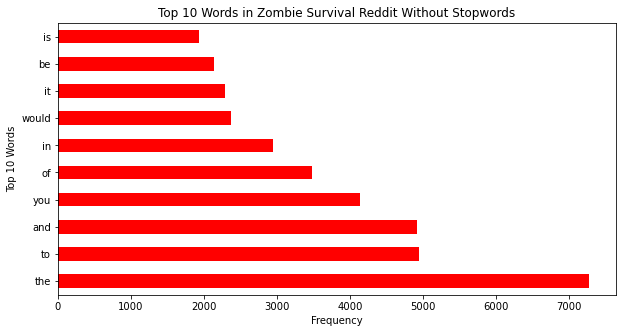

In [11]:
# Plot of top occuring words across all documents - a lot of these are stop words - articles
plt.figure(figsize=(10,5))
subred_1_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='red')
plt.title("Top 10 Words in Zombie Survival Reddit Without Stopwords", c='black', horizontalalignment='center')
plt.ylabel("Top 10 Words", size=10, c='black')
plt.xlabel("Frequency", c="black")
plt.savefig('./images/z_10_single_no_stopwords.png');

 This is unhelpful to our model as the top words are mostly articles and stop words.

In [12]:
# We create stop words so the model only picks up essential words to improve classification identification.  
# I am removing the words zombie and apocalypse to make it harder for the model to identify the subreddit.
# I added other URL words and non-informative reoccuring words.

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
my_words=['zombie','zombies','apocalypse', "https", "amp", "com", "poll", "www", "reddit", "don", "webp", "youtube", "reddit", "like","just", "ve", "need", "people", "think", "know", 
         "redd"]
my_stop_words=ENGLISH_STOP_WORDS.union(my_words)

In [13]:
# Subreddit 1's texts
subred_1=combined_db[combined_db['subreddit']==1]['all_text']

In [14]:
# Instiate and set parameters using stop words
cvec = CountVectorizer(stop_words=my_stop_words,
                       min_df=3, # Words must appear a minimum of 3 times
                       max_df=.98, # Ignore words that appear in 98% of documents in the corpus.
                       max_features=1_000,  # The top 1,000 words will be saved
                       ngram_range=(1,3)
                      )

# Fit our vectorizier on our corpus
cvec.fit(subred_1)

# Transform the corpus
subred_1 = cvec.transform(subred_1)

In [15]:
## Check some of the word features stored in CountVectorizer with `get_feature_names`
# cvec.get_feature_names()[100:150]

In [16]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
subred_1_df = pd.DataFrame(subred_1.todense(), 
                          columns=cvec.get_feature_names())

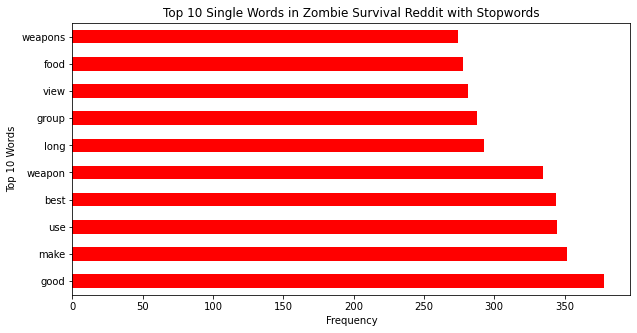

In [17]:
# Plot of top occuring words across all documents - a lot of these are stop words still
plt.figure(figsize=(10,5))
subred_1_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='red')
plt.title("Top 10 Single Words in Zombie Survival Reddit with Stopwords", c='black', horizontalalignment='center')
plt.ylabel("Top 10 Words", size=10, c='black')
plt.xlabel("Frequency", c="black")
plt.savefig('./images/z_10_single_stopwords.png');

 "make", "use", "weapon", "best" seem to indicate those in the ZST (Zombie Survival Tactics Reddit) use language revolving inquiring about the best options available or to make to survive an outbreak.

In [18]:
combined_db.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,all_text
0,What have you prepared for ww3,I have been prepping since September. And had ...,0,1644716942,Vote_for_my_party,0,1,True,2022-02-12,what have you prepared for ww3 i have been pre...
1,Food storage,I trust you idiots more than Amazon reviews 😉\...,0,1644722444,FrostyyFalcon,0,1,True,2022-02-12,food storage i trust you idiots more than amaz...
2,bug out buddies welcome,NaN,0,1644728273,nurseandmeddoctor,1,1,True,2022-02-12,bug out buddies welcome
3,Watch Online,I'm looking for a place/website to watch certa...,0,1644742724,Rocaine300,0,1,True,2022-02-13,watch online i'm looking for a place/website t...
4,Watch Online,I'm looking for a website/place to watch certa...,0,1644742990,The_Bawsz,0,1,True,2022-02-13,watch online i'm looking for a website/place t...


In [19]:
# Subreddit 1's texts
subred_1=combined_db[combined_db['subreddit']==1]['all_text']

In [19]:
# Subreddit 1's texts
subred_1=combined_db[combined_db['subreddit']==1]['all_text']

In [20]:
subred_1.head()

2400    do you guys think that a za gonna happen anyti...
2401    voodoo zombies. they cannot be killed, how do ...
2402    a zombie joke imagine fantasizing all your lif...
2403    what would be your reaction to saviour type gr...
2404    looking for a zombie apocalypse preparedness a...
Name: all_text, dtype: object

In [21]:
# Instiate and set parameters using stop words
cvec = CountVectorizer(stop_words=my_stop_words,
                       min_df=3, # Words must appear a minimum of 3 times
                       max_df=.98, # Ignore words that appear in 98% of documents in the corpus.
                       max_features=1_000,  # The top 1,000 words will be saved
                       ngram_range=(2,3)
                  )

# Fit our vectorizier on our corpus
cvec.fit(subred_1)

# Transform the corpus
subred_1 = cvec.transform(subred_1)

In [22]:
## Check some of the word features stored in CountVectorizer with `get_feature_names`
# cvec.get_feature_names()[100:150]

In [23]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
subred_1_df = pd.DataFrame(subred_1.todense(), 
                          columns=cvec.get_feature_names())

In [23]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
Full_df_txt_1 = pd.DataFrame(Full_df_txt.todense(), 
                          columns=cvec.get_feature_names())

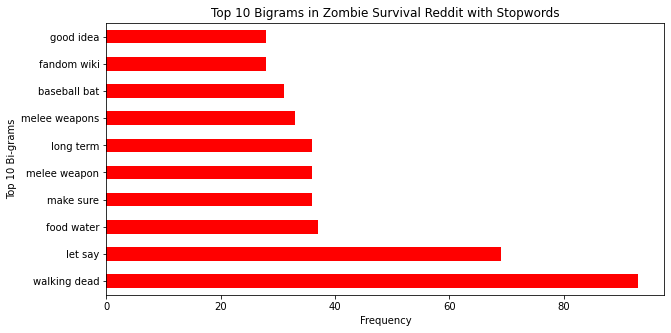

In [24]:
# Plot of top occuring words across all documents - a lot of these are stop words - articles
plt.figure(figsize=(10,5))
subred_1_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='red')
plt.title("Top 10 Bigrams in Zombie Survival Reddit with Stopwords", c='black', horizontalalignment='center')
plt.ylabel("Top 10 Bi-grams", size=10, c='black')
plt.xlabel("Frequency", c="black")
plt.savefig('./images/z_10_bigrams_stopwords.png');

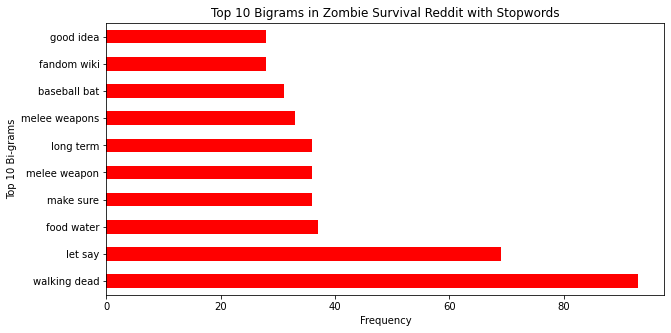

In [24]:
# Plot of top occuring words across all documents - a lot of these are stop words - articles
plt.figure(figsize=(10,5))
Full_df_txt_1.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='red')
plt.title("Top 10 Bigrams in Zombie Survival Reddit with Stopwords", c='black', horizontalalignment='center')
plt.ylabel("Top 10 Bi-grams", size=10, c='black')
plt.xlabel("Frequency", c="black")
plt.savefig('./images/z_10_bigrams_stopwords.png');

 Still not quite what imagined however, "walking dead","food water",  "melee weapon", "baseball bat" are insightful bigrams.
 We do have double words like 'melee weapon' and 'melee weapons'. Lemmetizing or porter may be more useful here.

# Subreddit 2
#### We are using count vectorizer to split and analyze the all_text columns in this section.
#### Visualization of the following are provided:

- Top 10 Most Frequently Occuring single words with and without stop-words
- Top 10 Most Frequently Occuring Bi-grams

In [25]:
# Subreddit 1's texts
subred_0=combined_db[combined_db['subreddit']==0]['all_text']

In [26]:
# Instiate and set parameters using stop words
cvec = CountVectorizer( 
                       min_df=3, # Words must appear a minimum of 3 times
                       max_df=.98, # Ignore words that appear in 98% of documents in the corpus.
                       max_features=1_000,  # The top 1,000 words will be saved
                       #ngram_range=(1,3)
                      )

# Fit our vectorizier on our corpus
cvec.fit(subred_0)

# Transform the corpus
subred_0 = cvec.transform(subred_0)

In [27]:
## Check some of the word features stored in CountVectorizer with `get_feature_names`
# cvec.get_feature_names()[100:150]

In [28]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
subred_0_df = pd.DataFrame(subred_0.todense(), 
                          columns=cvec.get_feature_names())

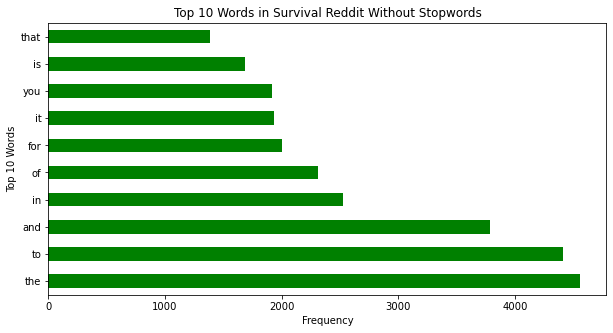

In [29]:
# Plot of top occuring words across all documents - a lot of these are stop words - articles
plt.figure(figsize=(10,5))
subred_0_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',  color='green')
plt.title("Top 10 Words in Survival Reddit Without Stopwords", c='black', horizontalalignment='center')
plt.ylabel("Top 10 Words", size=10, c='black')
plt.xlabel("Frequency", c="black")
plt.savefig('./images/s_10_single_no_stopwords.png');

 This is unhelpful to our model as the top words are mostly articles and stop words.

In [35]:
# Subreddit 1's texts
subred_0=combined_db[combined_db['subreddit']==0]['all_text']

In [36]:
# Instiate and set parameters using stop words
cvec = CountVectorizer(stop_words=my_stop_words,
                       min_df=3, # Words must appear a minimum of 3 times
                       max_df=.98, # Ignore words that appear in 98% of documents in the corpus.
                       max_features=1_000,  # The top 1,000 words will be saved
                       ngram_range=(1,2)
                      )

# Fit our vectorizier on our corpus
cvec.fit(subred_0)

# Transform the corpus
subred_0 = cvec.transform(subred_0)

In [37]:
## Check some of the word features stored in CountVectorizer with `get_feature_names`
# cvec.get_feature_names()[100:150]

In [38]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
subred_0_df = pd.DataFrame(subred_0.todense(), 
                          columns=cvec.get_feature_names())

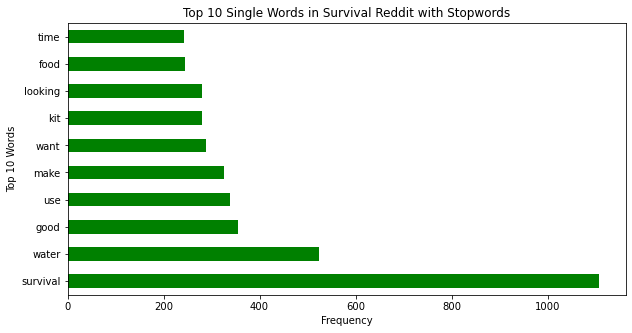

In [39]:
# Plot of top occuring words across all documents - a lot of these are stop words still
plt.figure(figsize=(10,5))
subred_0_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',  color='green')
plt.title("Top 10 Single Words in Survival Reddit with Stopwords", c='black', horizontalalignment='center')
plt.ylabel("Top 10 Words", size=10, c='black')
plt.xlabel("Frequency", c="black")
plt.savefig('./images/s_10_single_stopwords.png');

 In contrast to the ZST, the survival reddit seems to be centered around usefulness regarding words as "good", "kit", and potentially even "time" depending on the context.
"Water" seems like the biggest concern for this group where as ZST had "weapon" being the most insightful word.

In [40]:
# Subreddit 1's texts
subred_0=combined_db[combined_db['subreddit']==0]['all_text']

In [41]:
# Instiate and set parameters using stop words
cvec = CountVectorizer(stop_words=my_stop_words,
                       min_df=3, # Words must appear a minimum of 3 times
                       max_df=.98, # Ignore words that appear in 98% of documents in the corpus.
                       max_features=1_000,  # The top 1,000 words will be saved
                       ngram_range=(2,3)
                      )

# Fit our vectorizier on our corpus
cvec.fit(subred_0)

# Transform the corpus
subred_0 = cvec.transform(subred_0)

In [42]:
## Check some of the word features stored in CountVectorizer with `get_feature_names`
# cvec.get_feature_names()[100:150]

In [43]:
# Convert X_train into a DataFrame.
# We will not actually use this for modeling,
# this is just to visualize what is happening
subred_0_df = pd.DataFrame(subred_0.todense(), 
                          columns=cvec.get_feature_names())

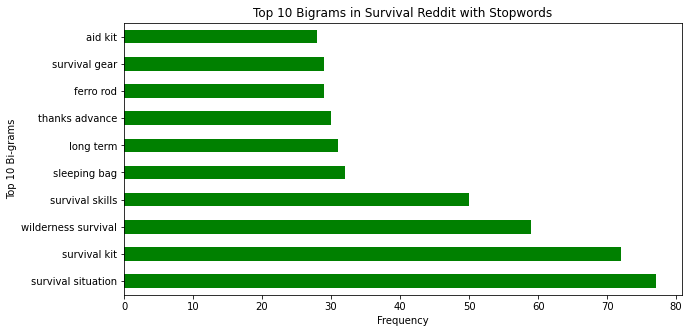

In [44]:
# Plot of top occuring words across all documents - a lot of these are stop words 
plt.figure(figsize=(10,5))
subred_0_df.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='green')
plt.title("Top 10 Bigrams in Survival Reddit with Stopwords", c='black', horizontalalignment='center')
plt.ylabel("Top 10 Bi-grams", size=10, c='black')
plt.xlabel("Frequency", c="black")
plt.savefig('./images/s_10_bigrams_stopwords.png');

 This by far is the most informative graph as we see key pairings in the subreddit such as "survival situation","survival kit", and "wilderness survival" leading, but also key words such as "sleeping bag", "survival kit", and even "survival gear"

# Preprocessing & Modeling
I use NLP to train a classifier on which subreddit a given post came from using binary classification. I tried a variety of models from logistic regression using count vectorizer, multinomial naive bayes using tf-idf vectorizer, and random forest using count vectorizer and tf-idf vectorizer

In [38]:
# Define X and y categories for our models
combined_db=pd.read_csv('./datasets/combined_db.csv')
X = combined_db['all_text']
y = combined_db['subreddit']

In [39]:
# Check the distribution of classes for balanced data which is perfectly balanced in this case at 50% for each class.
# Based on a naive bayes model we would predict the majority class here
y.value_counts(normalize = True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [40]:
# Split the data into the training and testing sets for our models
X_train, X_test, y_train, y_test = train_test_split (X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)
print(X_train.shape)
print(X_test.shape)

(3216,)
(1584,)


## Models
Note: Model code adapted from General Assembly's NLP lessons

# Count Vectorizer and Logistic Regression Model Test #1

In [44]:
# Instiate,set parameters, and establish a gridsearch and pipeline to find the best combinations for the model
# The parameters have been adjusting after running the model numerous times

pipe = Pipeline([
    ('cv', CountVectorizer(stop_words=my_stop_words)),
    ('lr', LogisticRegression())
])

params = {
    'cv__min_df':[2, 3],
    'cv__max_df': [.65, .70, .75,],
    'cv__max_features': [2_000, 2_500, 3_000, 3_500],
    'cv__ngram_range':[(1,1), (1,2), (2,3)],
    
    'lr__penalty':['l2', 'l1'],  #ridge or lasso
    'lr__class_weight' : [None, 'balanced'],
    'lr__solver': [ 'lbfgs', 'liblinear'], 
    'lr__C': [0.001, 1, 10]  #alpha
}

gs = GridSearchCV(pipe,
                  params, 
                  cv=5, 
                  verbose=1, 
                  n_jobs=-1)

gs.fit(X_train, y_train)

print(f'Best Params: {gs.best_params_}')
print(f'Best Training Score: {gs.score(X_train, y_train)}')           
print(f'Best Testing Score: {gs.score(X_test, y_test)}')

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 8640 out of 8640 | elapsed:  6.8min finished


Best Params: {'cv__max_df': 0.65, 'cv__max_features': 3500, 'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'lr__C': 1, 'lr__class_weight': None, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Best Training Score: 0.9704601990049752
Best Testing Score: 0.8516414141414141


# Confusion Matrix code below

In [45]:
# Generate predicitions
preds = gs.predict(X_test)

# Save confusion matrix values
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

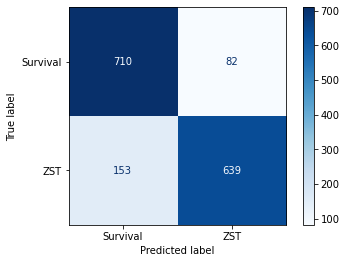

In [46]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', display_labels=['Survival', 'ZST'])
plt.savefig('./images/lr_cm.png');

In [47]:
# Our model has incorrectly classified 166 subrredits as reddit 0 (Survival) - False Negative
# Our model has incorrectly classified 71 subreddits as reddit 1 (Zombie Survival Tactics) - False Positives

In [48]:
# https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e
print('Accuracy Score : ' + str(accuracy_score(y_test, preds))) # % of obs guess correctly
print('Precision Score : ' + str(precision_score(y_test,preds))) # correctly predicted the true positives out of all the positive predictions made? 
print('Sensitivity Score (Recall) : ' + str(recall_score(y_test,preds))) #  of all the positive classs guess how many did I get correct (1's-ZST) 
print(f"Specificity: {tn/ (tn + fp)}") # of all the negatives class how many did I get correct. The moidel is doing the best at predicting the negatives
print('F1 Score: '+ str(f1_score(y_test, preds))) #the balance of sensitivity and precision # We are doing 34% better than baseline of 50/50.

Accuracy Score : 0.8516414141414141
Precision Score : 0.8862690707350902
Sensitivity Score (Recall) : 0.8068181818181818
Specificity: 0.8964646464646465
F1 Score: 0.8446794448116326


# Next we'll try our other model and compare the results
- TF-IDF and Multinomial Naive Bayes - Model Test #2

In [91]:
# The parameters have been adjusting after running the model numerous times


# Let's set a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)


pipe_tvec=Pipeline([
    ("tvec", TfidfVectorizer(stop_words=my_stop_words)),
    ("mnb", MultinomialNB())
])


pipe_tvec_params = {
    "tvec__max_features":[4_300, 4_400, 4_500], ## keeps the N most frequently occuring terms
    "tvec__ngram_range":[(1,1), (1,2)], ## include 1-grams, or both 1-grams and 2-grams    
    "tvec__min_df":[2, 3], ## remove words that don't show up enough
    "tvec__max_df": [.65, .70], ## remove words that show up too much
    'mnb__alpha':[0.001, 0.0001, 1, 10]
}
gs_tvec = GridSearchCV(estimator = pipe_tvec, # we are optimizing on pip_tvec
                  param_grid = pipe_tvec_params, # set params
                  cv = 5, # 5-fold cross-validation.
                  verbose = 1,
                 n_jobs=-1)

# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)


print(f'Best Params: {gs_tvec.best_params_}')
print(f'Best Training Score: {gs_tvec.score(X_train, y_train)}')           
print(f'Best Testing Score: {gs_tvec.score(X_test, y_test)}')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   15.8s finished


Best Params: {'mnb__alpha': 1, 'tvec__max_df': 0.65, 'tvec__max_features': 4400, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Best Training Score: 0.9328358208955224
Best Testing Score: 0.8768939393939394


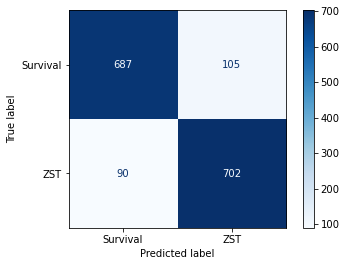

In [92]:
# visualize this (by plotting the confusion matrix)
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap="Blues", values_format="d",display_labels=['Survival', 'ZST'])
plt.savefig('./images/mnb_cm.png');

In [93]:
preds_tvec = gs_tvec.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test, preds_tvec))) # % of obs guess correctly
print('Precision Score : ' + str(precision_score(y_test,preds_tvec))) # correctly predicted the true positives out of all the positive predictions made? 
print('Sensitivity Score (Recall) : ' + str(recall_score(y_test,preds_tvec))) #  of all the positive classs guess how many did I get correct (1's-ZST) 
print('F1 Score: '+ str(f1_score(y_test, preds_tvec))) #the balance of sensitivity and precision # We are doing 37% better than baseline of 50/50.

Accuracy Score : 0.8768939393939394
Precision Score : 0.8698884758364313
Sensitivity Score (Recall) : 0.8863636363636364
F1 Score: 0.8780487804878049


Compared to the logistic regression model our training, test, and all our evaluation scores improved using a TF-IDF and Multinomial Naive Bayes model. The MNB model had an 18% improvement in classification accuracy over our logistic regression. This could be because multinomial naive baye classifiers are more suitable for text classification problems.

## Using TfidfTransformer to gridsearch between CountVectorizer and TfidfVectorizer with Random Forest - Model test #3

In [64]:
# The parameters have been adjusting after running the model numerous times

# Let's set a pipeline up with three stages:
# 1. CountVectorizer (transformer)
# 2. TfidfTransformer (transformer) - allows us the option of applying IDF
# 2. Random Forest Classifier (estimator)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,
                                                     stratify=y, random_state=42)

cvec_idf_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=my_stop_words)),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier())
])

pipe_params_cidf = {
        'cvec__max_features' : [2_500, 3_000, 3_500],
        'cvec__ngram_range' : [(1,1), (1,2)],
        'cvec__min_df' : [2, 3],
        'tfidf__use_idf' : [True, False] ,
        'rf__ccp_alpha': [ 0.0001, 0.001], 
        'rf__n_estimators': [50, 75, 100],
        'rf__max_depth' : [10, 15, 20],
        'rf__min_samples_leaf': [1, 2], 
        'rf__min_samples_split': [2, 3],
        'rf__class_weight' : [None, "balanced"]
}


# Instantiate GridSearchCV.
gs_cvec_idf = GridSearchCV(cvec_idf_pipe,
                      param_grid=pipe_params_cidf,
                      cv=5,
                      verbose=1,
                      n_jobs=6)



# Fit GridSearch to training data.
gs_cvec_idf.fit(X_train, y_train)

print(f'Best Params: {gs_cvec_idf.best_params_}')
print(f'Best Training Score: {gs_cvec_idf.score(X_train, y_train)}')           
print(f'Best Testing Score: {gs_cvec_idf.score(X_test, y_test)}')

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.8s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   15.8s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   35.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  6.8min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  8.6min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed: 10.7min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed: 12.1min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 16.8min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 19.8mi

Best Params: {'cvec__max_features': 3500, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'rf__ccp_alpha': 0.0001, 'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'tfidf__use_idf': False}
Best Training Score: 0.888681592039801
Best Testing Score: 0.803030303030303


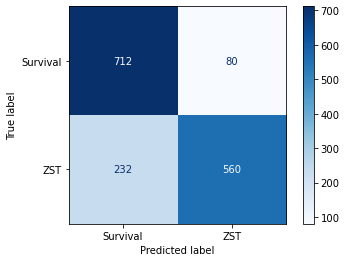

In [65]:
# visualize this (by plotting the confusion matrix)
plot_confusion_matrix(gs_cvec_idf, X_test, y_test, cmap="Blues", values_format="d",display_labels=['Survival', 'ZST'])
plt.savefig('./images/rf_cm.png');;

In [67]:
# Get predictions
preds_cvec_idf = gs_cvec_idf.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvec_idf ).ravel()

print('Accuracy Score : ' + str(accuracy_score(y_test, preds_cvec_idf))) # % of obs guess correctly
print('Precision Score : ' + str(precision_score(y_test,preds_cvec_idf))) # correctly predicted the true positives out of all the positive predictions made? 
print('Sensitivity Score : ' + str(recall_score(y_test,preds_cvec_idf))) #  How many of the positive class guessed correctly of all the positives (1's-ZST) 
print('F1 Score: '+ str(f1_score(y_test, preds_cvec_idf))) # We are doing 28% better than baseline of 50/50.

Accuracy Score : 0.803030303030303
Precision Score : 0.875
Sensitivity Score : 0.7070707070707071
F1 Score: 0.7821229050279329


## Model comparison

In [95]:
print('~~~~~~~~~~~~~~~~~')
print(f'Logistic Regression with CVEC')
print(f'Best Params: {gs.best_params_}')
print(f'Best Training Score: {gs.score(X_train, y_train)}')           
print(f'Best Testing Score: {gs.score(X_test, y_test)}')
print('Accuracy Score : ' + str(accuracy_score(y_test, preds))) 
print('Precision Score : ' + str(precision_score(y_test,preds))) 
print('Sensitivity Score (Recall) : ' + str(recall_score(y_test,preds))) 
print(f"Specificity: {tn/ (tn + fp)}") 
print('F1 Score: '+ str(f1_score(y_test, preds))) 

print('~~~~~~~~~~~~~~~~~')
print(f'MNB with TF-IDF')
print(f'Best Params: {gs_tvec.best_params_}')
print(f'Best Training Score: {gs_tvec.score(X_train, y_train)}')           
print(f'Best Testing Score: {gs_tvec.score(X_test, y_test)}')
print('Accuracy Score : ' + str(accuracy_score(y_test, preds_tvec)))
print('Precision Score : ' + str(precision_score(y_test,preds_tvec))) 
print('Sensitivity Score (Recall) : ' + str(recall_score(y_test,preds_tvec))) 
print('F1 Score: '+ str(f1_score(y_test, preds_tvec)))

print('~~~~~~~~~~~~~~~~~')
print(f'RF with CVEC')
print(f'Best Params: {gs_cvec_idf.best_params_}')
print(f'Best Training Score: {gs_cvec_idf.score(X_train, y_train)}')           
print(f'Best Testing Score: {gs_cvec_idf.score(X_test, y_test)}')
print('Accuracy Score : ' + str(accuracy_score(y_test, preds_cvec_idf))) 
print('Precision Score : ' + str(precision_score(y_test,preds_cvec_idf))) 
print('Sensitivity Score : ' + str(recall_score(y_test,preds_cvec_idf)))
print('F1 Score: '+ str(f1_score(y_test, preds_cvec_idf))) 



~~~~~~~~~~~~~~~~~
Logistic Regression with CVEC
Best Params: {'cv__max_df': 0.65, 'cv__max_features': 3500, 'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'lr__C': 1, 'lr__class_weight': None, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Best Training Score: 0.9704601990049752
Best Testing Score: 0.8516414141414141
Accuracy Score : 0.8516414141414141
Precision Score : 0.8862690707350902
Sensitivity Score (Recall) : 0.8068181818181818
Specificity: 0.898989898989899
F1 Score: 0.8446794448116326
~~~~~~~~~~~~~~~~~
MNB with TF-IDF
Best Params: {'mnb__alpha': 1, 'tvec__max_df': 0.65, 'tvec__max_features': 4400, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Best Training Score: 0.9328358208955224
Best Testing Score: 0.8768939393939394
Accuracy Score : 0.8768939393939394
Precision Score : 0.8698884758364313
Sensitivity Score (Recall) : 0.8863636363636364
F1 Score: 0.8780487804878049
~~~~~~~~~~~~~~~~~
RF with CVEC
Best Params: {'cvec__max_features': 3500, 'cvec__min_df': 3, 'cvec__ngram_range

After cleaning, plotting, and numerous (logistic regression with count vec, multinomial naive bayes with tdidf and stopwords, random forest with count vec) model testing on the all_text column, the best performing model was the mnb with tdidf. Comparing the three models the random forest model performed the worst. It has the lowest performing metric scores of all the models across the board and has the highest amount of misclassifications. While the variance between the train and test is only 8% compared to the logistic regression with a 12% difference, but the mnb model still has the lowest difference at 6%. The MNB model has the highest accuracy with the least amount of misclassifications coming it at 87%. It has the lowest precision score by just 2% range still fairing well in prediction true positives from all positive preditions.

The MNB model has the highest accuracy with the least amount of misclassifications coming it at 87%. It has the lowest precision score by just 2% range still fairing well in prediction true positives from all positive predictions. The mnb model had the highest sensitivity score showing can reduce false negatives much better than the other models. Its f1 score has the highest balance between precision and sensitivity. The after multiple parameter tuning the lowest max__df and highest max_features seemed to generate the best scores. Because multinomial naive bayes classifiers are more suitable for text classification problems this could be the reason it faired better than the other models.  While there is still room for improvement, the mnb model is our chosen model as it classifies reddit posts with the highest accuracy.

## Bonus!
### MNB with TFIDF without stop words
- To see how easily our best model can predict the subreddit without the limit of strong giveaway words like "zombie" and "apocalypse"

In [88]:
# The parameters have been adjusting after running the model numerous times


# Let's set a pipeline up with two stages:
# 1. tf-idf vectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)


pipe_tvec=Pipeline([
    ("tvec", TfidfVectorizer()),
    ("mb", MultinomialNB())
])


pipe_tvec_params = {
    "tvec__max_features":[4_300, 4_400, 4_500], ## keeps the N most frequently occuring terms
    "tvec__ngram_range":[(1,1), (1,2)], ## include 1-grams, or both 1-grams and 2-grams    
    "tvec__min_df":[2, 3], ## remove words that don't show up enough
    "tvec__max_df": [.65, .70], ## remove words that show up too much
    'mb__alpha':[0.001, 0.0001, 1, 10]
}
gs_tvecs = GridSearchCV(estimator = pipe_tvec, # we are optimizing on pip_tvec
                  param_grid = pipe_tvec_params, # set params
                  cv = 5, # 5-fold cross-validation.
                  verbose = 1,
                 n_jobs=-1)

# Fit GridSearch to training data.
gs_tvecs.fit(X_train, y_train)


print(f'Best Params: {gs_tvecs.best_params_}')
print(f'Best Training Score: {gs_tvecs.score(X_train, y_train)}')           
print(f'Best Testing Score: {gs_tvecs.score(X_test, y_test)}')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:   25.4s finished


Best Params: {'mb__alpha': 0.001, 'tvec__max_df': 0.65, 'tvec__max_features': 4300, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
Best Training Score: 0.9402985074626866
Best Testing Score: 0.9065656565656566


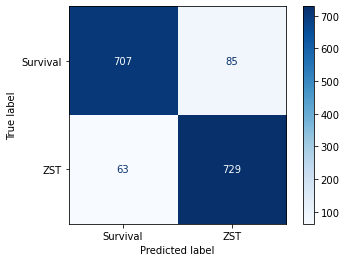

In [89]:
# visualize this (by plotting the confusion matrix)
plot_confusion_matrix(gs_tvecs, X_test, y_test, cmap="Blues", values_format="d",display_labels=['Survival', 'ZST'])
plt.savefig('./images/mnb_no_stop_words_cm.png');

In [90]:
preds_tvec = gs_tvecs.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test, preds_tvec))) # % of obs guess correctly
print('Precision Score : ' + str(precision_score(y_test,preds_tvec))) # correctly predicted the true positives out of all the positive predictions made? 
print('Sensitivity Score (Recall) : ' + str(recall_score(y_test,preds_tvec))) #  of all the positive classs guess how many did I get correct (1's-ZST) 
print('F1 Score: '+ str(f1_score(y_test, preds_tvec))) #the balance of sensitivity and precision # We are doing 37% better than baseline of 50/50.

Accuracy Score : 0.9065656565656566
Precision Score : 0.8955773955773956
Sensitivity Score (Recall) : 0.9204545454545454
F1 Score: 0.9078455790784558


Sure enough training score increased by 1%, and testing score by 3%. The metric scores are the highest across the board without the TDIDF stop words. The sensitivity increased by 4%, precision by 2%, and both accuracy and f1 by 3%. 

# Conclusion/Final Recommendations
- Multinomial Naive Bayes is the best performing model to properly classify subreddit post origins. It had the highest accuracy and the best sensitivity score across the board minimizing  false negatives
- If strong identifying words like "zombie" and "apocalypse were to be removed the training and test scores jump to 90% and 94% respectively with the highest metric scores
- As my goal was to optimize in accuracy and reducing misclassifications the MNB fits the goals wells

My recommendation for the television and movie market is to use multinomial naive bayes modeling to accurately identify the topics, discussions, and desires of survivalist, preppers, and doomsday zombie fans. The insight gained would allow for a potential greater audience to be reached and accurately catering to their needs and making hit shows like The Walking Dead which was the top occurring bigram in the Zombie Survival Tactic subreddit. With 3.7 million Americans classifying themselves as survivalist, 14% having zombie survival plan, and a $107 billion survivalist market the potential to make not only shows, movies, but also products aimed in survival situations could lead to a greater ROI as both subreddits had "use, "best", and "good" as top words. A future study should be explored using poll data, using lemmatization, and the /r/Preppers subreddit to provide greater insight to this target market as well.

## References: 
- https://www.reddit.com/r/Survival/
- https://www.reddit.com/r/ZombieSurvivalTactics/
- https://thinkgrowth.org/the-doom-boom-inside-the-survival-industry-s-explosive-growth-2fece1f6cd6c
- https://trends.google.com/trends/explore?date=today%205-y&geo=US&q=survival,zombie
- https://today.yougov.com/topics/entertainment/articles-reports/2019/10/01/zombie-apocalypse-plan
- https://thehustle.co/coronavirus-prepping-doomsday-business/
- https://www.alliedmarketresearch.com/incident-and-emergency-management-market
